<a href="https://colab.research.google.com/github/Wongcheukwai/E-Commerce_Recommendation_Prediction/blob/main/Customer_Recommendation_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background and Shit
You work for an online women's clothing retailer that wants to understand which products customers are likely to recommend to others. By predicting customer recommendations, the company can identify popular products, improve inventory management, and enhance their recommendation system to increase customer satisfaction and sales.
# Dataset Overview
The dataset contains customer reviews for various women's clothing products with the following features:

Clothing ID: Unique identifier for each product

Age: Age of the reviewer

Title: Title of the review

Review Text: Full text of the customer review

Rating: Customer rating (likely on a scale of 1-5)

Recommended IND: Binary indicator of whether the customer recommended the product (1) or not (0)

Positive Feedback Count: Number of other customers who found the review helpful

Division Name: Product's division category (e.g., General, Intimates)

Department Name: Product's department category (e.g., Tops, Dresses)

Class Name: Product's specific class (e.g., Blouses, Sweaters)

#Upload the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Set up enviroment

In [ ]:
# Install any additional required packages
!pip install transformers nltk scikit-learn matplotlib seaborn

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# For text processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Using device: cuda


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# EDA

Dataset shape: (23486, 11)

Sample data:


,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
5,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses
6,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits



--- MISSING VALUES ANALYSIS ---
                         Missing Values  Percentage
Clothing ID                           0         0.0
Age                                   0         0.0
Title                                 0         0.0
Review Text                           0         0.0
Rating                                0         0.0
Recommended IND                       0         0.0
Positive Feedback Count               0         0.0
Division Name                         0         0.0
Department Name                       0         0.0
Class Name                            0         0.0

--- NUMERICAL FEATURES DISTRIBUTIONS ---

--- CATEGORICAL FEATURES DISTRIBUTIONS ---

--- RELATIONSHIPS BETWEEN FEATURES AND TARGET ---


<ipython-input-3-e2cf5201030c>:147: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rec_by_age = df.groupby(age_groups)['Recommended IND'].mean() * 100



--- CORRELATION ANALYSIS ---


Text(0.5, 1.0, 'Correlation Between Features')

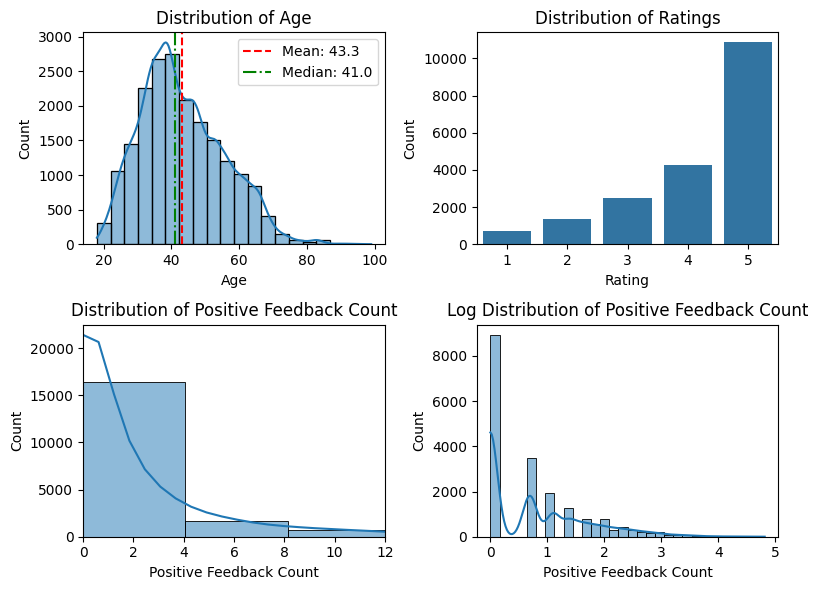

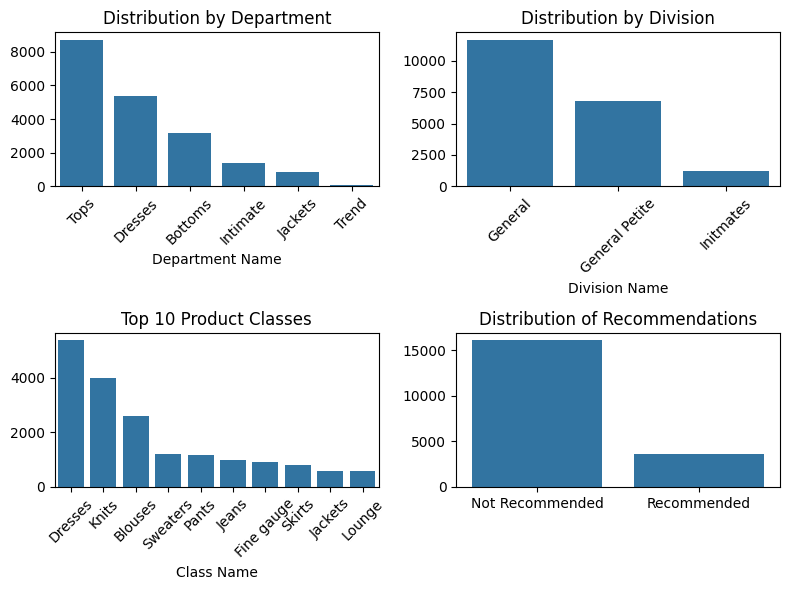

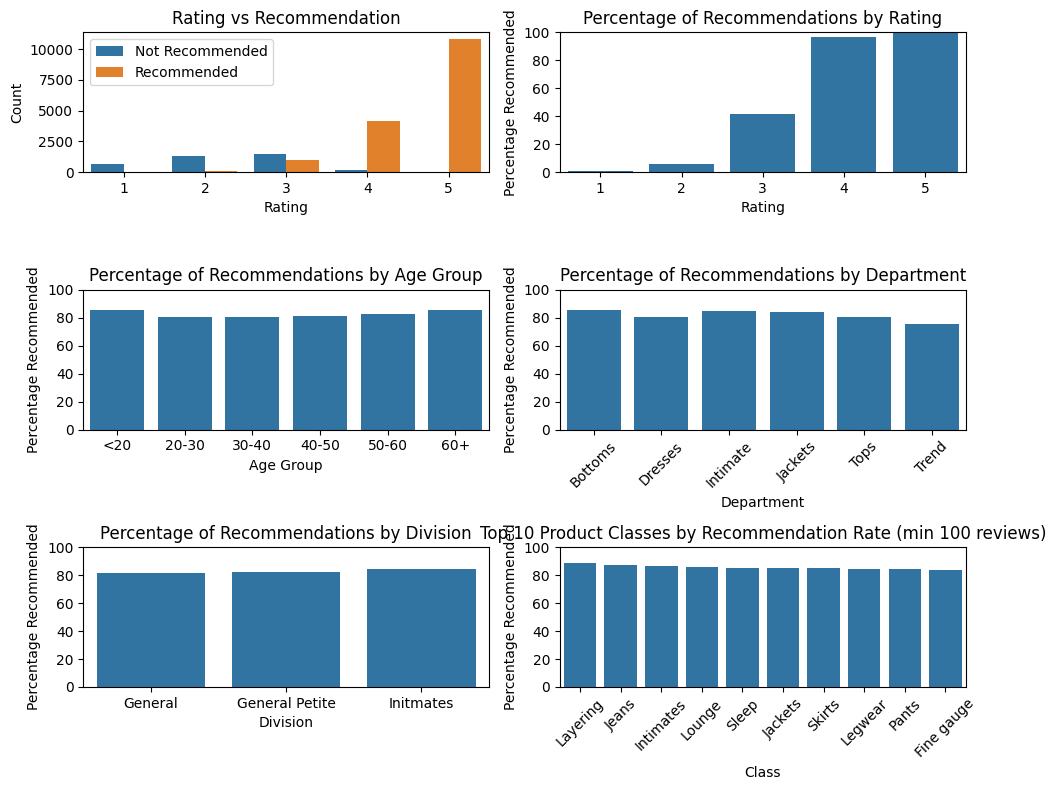

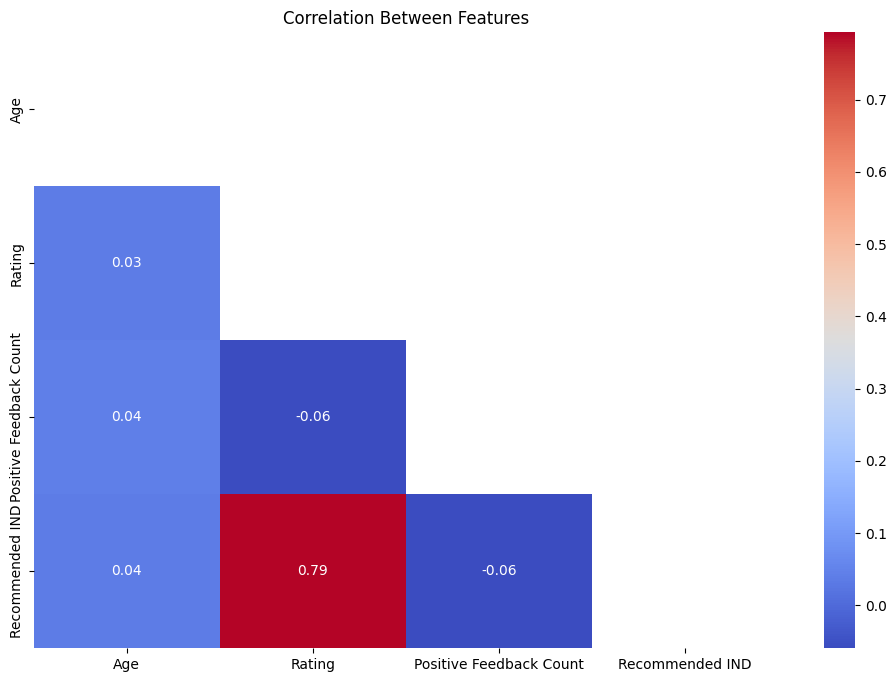

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data/women_clothes_reviews.csv')

print("Dataset shape:", df.shape)

# print("\nFeature information:")
# df.info()

# delete useless column
df.drop('Unnamed: 0', axis=1, inplace=True)


# delete all missing line
df.dropna(inplace=True)

print("\nSample data:")
display(df.head())


# print("\nBasic statistics:")
# display(df.describe())

# 1. Check for missing values
print("\n--- MISSING VALUES ANALYSIS ---")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})
#print(missing_df)

# delete all rows with nan
df.dropna(inplace=True)

# 1. Check for missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})
print(missing_df)

# Create a visualization of missing values
# plt.figure(figsize=(10, 6))
# sns.barplot(x=missing_df.index, y='Percentage', data=missing_df)
# plt.title('Percentage of Missing Values by Feature')
# plt.xticks(rotation=45)
# plt.ylim(0, 100)
# plt.tight_layout()
# plt.show()

# 2. Distribution of numerical features
print("\n--- NUMERICAL FEATURES DISTRIBUTIONS ---")

# Age distribution
plt.figure(figsize=(8, 6))
plt.subplot(2, 2, 1)
sns.histplot(df['Age'], bins=20, kde=True)
plt.title('Distribution of Age')
plt.axvline(df['Age'].mean(), color='r', linestyle='--', label=f'Mean: {df["Age"].mean():.1f}')
plt.axvline(df['Age'].median(), color='g', linestyle='-.', label=f'Median: {df["Age"].median():.1f}')
plt.legend()

# Rating distribution
plt.subplot(2, 2, 2)
rating_counts = df['Rating'].value_counts().sort_index()
sns.barplot(x=rating_counts.index, y=rating_counts.values)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')

# Positive Feedback Count distribution
plt.subplot(2, 2, 3)
sns.histplot(df['Positive Feedback Count'], bins=30, kde=True)
plt.title('Distribution of Positive Feedback Count')
plt.xlim(0, df['Positive Feedback Count'].quantile(0.95))  # Limit x-axis to handle outliers

# Log of Positive Feedback Count (to handle skewness)
plt.subplot(2, 2, 4)
sns.histplot(np.log1p(df['Positive Feedback Count']), bins=30, kde=True)
plt.title('Log Distribution of Positive Feedback Count')

plt.tight_layout()

# 3. Distribution of categorical features
print("\n--- CATEGORICAL FEATURES DISTRIBUTIONS ---")

# Department distribution
plt.figure(figsize=(8, 6))
plt.subplot(2, 2, 1)
dept_counts = df['Department Name'].value_counts()
sns.barplot(x=dept_counts.index, y=dept_counts.values)
plt.title('Distribution by Department')
plt.xticks(rotation=45)

# Division distribution
plt.subplot(2, 2, 2)
div_counts = df['Division Name'].value_counts()
sns.barplot(x=div_counts.index, y=div_counts.values)
plt.title('Distribution by Division')
plt.xticks(rotation=45)

# Class distribution (top 10)
plt.subplot(2, 2, 3)
class_counts = df['Class Name'].value_counts().head(10)
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Top 10 Product Classes')
plt.xticks(rotation=45)

# Recommendation distribution
plt.subplot(2, 2, 4)
rec_counts = df['Recommended IND'].value_counts()
sns.barplot(x=['Not Recommended', 'Recommended'], y=rec_counts.values)
plt.title('Distribution of Recommendations')
plt.tight_layout()

# 4. Distribution of Target Variable
# Check for class imbalance
# This has been checked previously

# 5. Relationships between features and target
print("\n--- RELATIONSHIPS BETWEEN FEATURES AND TARGET ---")

# 5.1 Rating vs Recommendation
plt.figure(figsize=(10, 8))
plt.subplot(3, 2, 1)
sns.countplot(x='Rating', hue='Recommended IND', data=df)
plt.title('Rating vs Recommendation')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.legend(['Not Recommended', 'Recommended'])

# Calculate percentage of recommendations by rating
rec_by_rating = df.groupby('Rating')['Recommended IND'].mean() * 100
plt.subplot(3, 2, 2)
sns.barplot(x=rec_by_rating.index, y=rec_by_rating.values)
plt.title('Percentage of Recommendations by Rating')
plt.xlabel('Rating')
plt.ylabel('Percentage Recommended')
plt.ylim(0, 100)

# 5.2 Age vs Recommendation
plt.subplot(3, 2, 3)
age_groups = pd.cut(df['Age'], bins=[0, 20, 30, 40, 50, 60, 100],
                    labels=['<20', '20-30', '30-40', '40-50', '50-60', '60+'])
rec_by_age = df.groupby(age_groups)['Recommended IND'].mean() * 100

sns.barplot(x=rec_by_age.index, y=rec_by_age.values)
plt.title('Percentage of Recommendations by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Percentage Recommended')
plt.ylim(0, 100)

# 5.3 Department vs Recommendation
plt.subplot(3, 2, 4)
rec_by_dept = df.groupby('Department Name')['Recommended IND'].mean() * 100
sns.barplot(x=rec_by_dept.index, y=rec_by_dept.values)
plt.title('Percentage of Recommendations by Department')
plt.xlabel('Department')
plt.ylabel('Percentage Recommended')
plt.ylim(0, 100)
plt.xticks(rotation=45)

# 5.4 Division vs Recommendation
plt.subplot(3, 2, 5)
rec_by_div = df.groupby('Division Name')['Recommended IND'].mean() * 100
sns.barplot(x=rec_by_div.index, y=rec_by_div.values)
plt.title('Percentage of Recommendations by Division')
plt.xlabel('Division')
plt.ylabel('Percentage Recommended')
plt.ylim(0, 100)

# 5.5 Top 10 Classes by Recommendation Rate
plt.subplot(3, 2, 6)
class_rec = df.groupby('Class Name')['Recommended IND'].agg(['mean', 'count'])
class_rec.columns = ['Recommendation Rate', 'Count']
class_rec['Recommendation Rate'] *= 100
# Filter for classes with at least 100 reviews
top_classes = class_rec[class_rec['Count'] >= 100].sort_values('Recommendation Rate', ascending=False).head(10)

sns.barplot(x=top_classes.index, y=top_classes['Recommendation Rate'])
plt.title('Top 10 Product Classes by Recommendation Rate (min 100 reviews)')
plt.xlabel('Class')
plt.ylabel('Percentage Recommended')
plt.ylim(0, 100)
plt.xticks(rotation=45)

plt.tight_layout()

# 7. Correlation Analysis
print("\n--- CORRELATION ANALYSIS ---")

# Create correlation matrix for numerical features
numerical_df = df[['Age', 'Rating', 'Positive Feedback Count', 'Recommended IND']].copy()
correlation = numerical_df.corr()

plt.figure(figsize=(12, 8))
mask = np.triu(correlation)
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', mask=mask)
plt.title('Correlation Between Features')




# Feature engineering

In [ ]:
# numberic
# 1. Standardize 'Age'
# Create a scaler for 'Age' and transform the feature so that it has a mean of 0 and standard deviation of 1.
scaler_age = StandardScaler()
df['Age_scaled'] = scaler_age.fit_transform(df[['Age']])

# 2. Standardize 'Rating'
# Treat 'Rating' as a continuous variable and standardize it similarly.
scaler_rating = StandardScaler()
df['Rating_scaled'] = scaler_rating.fit_transform(df[['Rating']])

# 3. Process 'Positive Feedback Count'
# First, apply a log transformation using np.log1p to reduce skewness.
df['Log_PosFeedback'] = np.log1p(df['Positive Feedback Count'])
# Then, standardize the log-transformed data.
scaler_feedback = StandardScaler()
df['Log_PosFeedback_scaled'] = scaler_feedback.fit_transform(df[['Log_PosFeedback']])

# Display a sample of the original and processed features for verification.
print(df[['Age', 'Age_scaled', 'Rating', 'Rating_scaled', 'Positive Feedback Count', 'Log_PosFeedback', 'Log_PosFeedback_scaled']].head())

# category
from sklearn.preprocessing import LabelEncoder

# ========== 1. One-Hot Encoding for 'Division Name' ==========
# Division only has 3 classes, suitable for one-hot
division_onehot = pd.get_dummies(df['Division Name'])
df = pd.concat([df, division_onehot], axis=1)

# ========== 2. Label Encoding for 'Department Name' ==========
# Suitable for Embedding Layer in neural networks
dept_le = LabelEncoder()
df['Department_encoded'] = dept_le.fit_transform(df['Department Name'])

# ========== 3. Label Encoding for 'Class Name' ==========
class_le = LabelEncoder()
df['Class_encoded'] = class_le.fit_transform(df['Class Name'])

### print text ###
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
import pandas as pd


# 2. Calculate sentiment polarity scores from the reviews
df['review_sentiment'] = df['Review Text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# 3. Use TF-IDF to vectorize the review text (limit to 10 features here for demo)
vectorizer = TfidfVectorizer(max_features=10, stop_words='english')
X_review_tfidf = vectorizer.fit_transform(df['Review Text'])

# 4. Concatenate the TF-IDF vectors with the sentiment score
X_text = torch.FloatTensor(X_review_tfidf.toarray())

# 5. Print the result
print("Shape of TF-IDF + Sentiment input:", X_text.shape)
print("First few rows of input:")
print(X_text[:5])  # Print the first 5 rows


   Age  Age_scaled  Rating  Rating_scaled  Positive Feedback Count  Log_PosFeedback  Log_PosFeedback_scaled
2   60    1.365594       3      -1.063792                        0         0.000000               -0.867332
3   50    0.549788       5       0.734452                        0         0.000000               -0.867332
4   47    0.305046       5       0.734452                        6         1.945910                1.308022
5   49    0.468207       2      -1.962914                        4         1.609438                0.931876
6   39   -0.347599       5       0.734452                        1         0.693147               -0.092455
Shape of TF-IDF + Sentiment input: torch.Size([19662, 10])
First few rows of input:
tensor([[0.2405, 0.0000, 0.2366, 0.0000, 0.2650, 0.0000, 0.0000, 0.2305, 0.8734,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.3423, 0.0000, 0.0000, 0.8795, 0.0000, 0.0000,
         0.3305],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6636, 0.000

# 🧩 Cell 1 – Prepare the input features

In [ ]:
print(df)
import torch

# Combine all structured + sentiment features
X_structured = torch.FloatTensor(df[[
    'Age_scaled', 'Rating_scaled', 'Log_PosFeedback_scaled',
    'Department_encoded', 'Class_encoded',
    'review_sentiment'
]].fillna(0.0).values)

# Final input features
X_all = torch.cat([X_structured, X_text], dim=1)

print(df)
# 将 tensor 转为 DataFrame，设置列名
X_all_df = pd.DataFrame(X_all.numpy())

# 设置结构化特征列名（按你顺序）
structured_cols = [
    'Age_scaled', 'Rating_scaled', 'Log_PosFeedback_scaled',
    'Department_encoded', 'Class_encoded', 'review_sentiment'
]

# 创建所有列名（结构化 + TF-IDF）
X_all_df.columns = structured_cols + [f'tfidf_{i}' for i in range(X_all.shape[1] - len(structured_cols))]

# 打印前几行查看
print(X_all_df.head())

# Labels
y = torch.FloatTensor(df['Recommended IND'].values).unsqueeze(1)

       Clothing ID  Age                                              Title                                        Review Text  Rating  Recommended IND  Positive Feedback Count   Division Name Department Name Class Name  Age_scaled  Rating_scaled  Log_PosFeedback  Log_PosFeedback_scaled  Department_encoded  Class_encoded  review_sentiment  General  General Petite  Initmates
2             1077   60                            Some major design flaws  I had such high hopes for this dress and reall...       3                0                        0         General         Dresses    Dresses    1.365594      -1.063792         0.000000               -0.867332                   1              3          0.073675     True           False      False
3             1049   50                                   My favorite buy!  I love, love, love this jumpsuit. it's fun, fl...       5                1                        0  General Petite         Bottoms      Pants    0.549788       0.734452   

#🧩 Cell 2 Split training/testting/validation set

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# Split: 70% train, 15% val, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(X_all, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# DataLoaders
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)

# 🧩 Cell 3 Define Neural Network and Loss Function

In [ ]:
import torch.nn as nn

# Simple feedforward neural network
class NNModel(nn.Module):
    def __init__(self, input_dim):
        super(NNModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),  # BN
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),  # BN
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize model
model = NNModel(X_all.shape[1])

import torch.optim as optim

loss_fn = nn.BCELoss()  # Binary classification
#optimizer = optim.Adam(model.parameters(), lr=1e-4)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5) # plus weight decay, its better


#🧩 Cell 4 Training *Pipeline*

In [ ]:
epochs = 20

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Compute average training loss
    avg_train_loss = total_loss / len(train_loader)

    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        val_preds = model(X_val)
        val_loss = loss_fn(val_preds, y_val).item()

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f}")

Epoch 1/20 | Train Loss: 0.2781 | Val Loss: 0.1608
Epoch 2/20 | Train Loss: 0.1761 | Val Loss: 0.1464
Epoch 3/20 | Train Loss: 0.1700 | Val Loss: 0.1388
Epoch 4/20 | Train Loss: 0.1690 | Val Loss: 0.1398
Epoch 5/20 | Train Loss: 0.1628 | Val Loss: 0.1388
Epoch 6/20 | Train Loss: 0.1624 | Val Loss: 0.1400
Epoch 7/20 | Train Loss: 0.1620 | Val Loss: 0.1394
Epoch 8/20 | Train Loss: 0.1605 | Val Loss: 0.1377
Epoch 9/20 | Train Loss: 0.1617 | Val Loss: 0.1369
Epoch 10/20 | Train Loss: 0.1607 | Val Loss: 0.1379
Epoch 11/20 | Train Loss: 0.1613 | Val Loss: 0.1365
Epoch 12/20 | Train Loss: 0.1619 | Val Loss: 0.1367
Epoch 13/20 | Train Loss: 0.1592 | Val Loss: 0.1373
Epoch 14/20 | Train Loss: 0.1608 | Val Loss: 0.1369
Epoch 15/20 | Train Loss: 0.1549 | Val Loss: 0.1369
Epoch 16/20 | Train Loss: 0.1567 | Val Loss: 0.1387
Epoch 17/20 | Train Loss: 0.1572 | Val Loss: 0.1369
Epoch 18/20 | Train Loss: 0.1564 | Val Loss: 0.1464
Epoch 19/20 | Train Loss: 0.1567 | Val Loss: 0.1362
Epoch 20/20 | Train L

#🧩 Cell 5 Testing

lr 0.01

--- Classification Report ---
              precision    recall  f1-score   support

         0.0     0.8149    0.9051    0.8576       569
         1.0     0.9767    0.9509    0.9636      2381

    accuracy                         0.9420      2950
   macro avg     0.8958    0.9280    0.9106      2950
weighted avg     0.9455    0.9420    0.9432      2950

ROC AUC Score: 0.9773


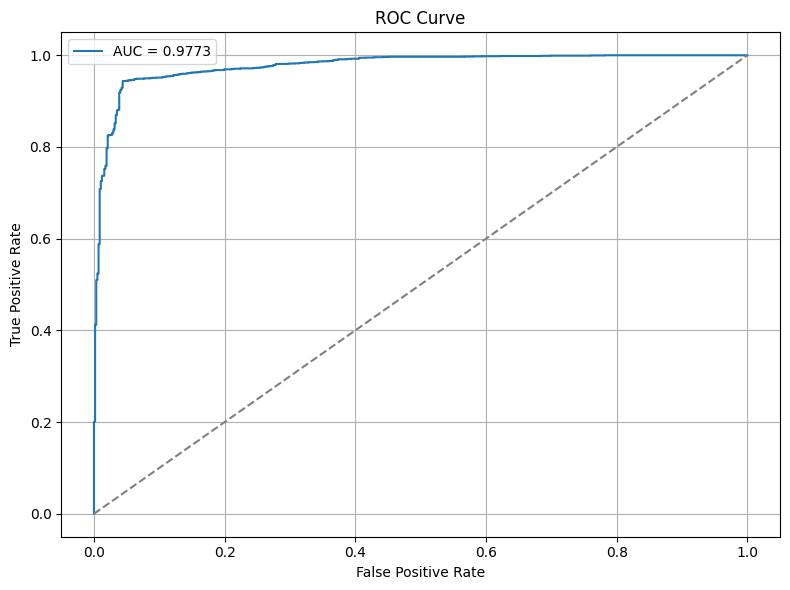

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Switch model to evaluation mode
model.eval()
with torch.no_grad():
    # Get predicted probabilities
    test_probs = model(X_test).cpu().numpy().flatten()

    # Binary predictions based on 0.5 threshold
    test_preds = (test_probs > 0.5).astype(int)

    # Ground truth
    y_true = y_test.cpu().numpy().flatten()
print('lr', lr)
# 1. Accuracy, Precision, Recall, F1
print("\n--- Classification Report ---")
print(classification_report(y_true, test_preds, digits=4))

# 3. ROC AUC Score
roc_auc = roc_auc_score(y_true, test_probs)
print(f"ROC AUC Score: {roc_auc:.4f}")

# 4. ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, test_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()